# **Project Notebook**

This notebook contains the code work for Data Science project "Uncertainty quantification of deep neural networks for high-dimensional data" for the CS-E4875 course.

For the data I've decided to use the "Predict Student Performance from Game Play" dataset from Kaggle: https://www.kaggle.com/competitions/predict-student-performance-from-game-play/data?select=sample_submission.csv The data aims to predict students performance for questions, given their past performance. This is a proxy task for something I currently work on in my dayjob so it should pose an interesting problem to tackle. 

Let's load the the data and explore it a bit:

In [1]:
# imports
import pandas as pd
import dask.dataframe as dd
import dask
import pyarrow.parquet as pq

from functools import partial
from itertools import chain

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn




/opt/software/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


## Model with mock data
I'll re-implement the model below, using the version from https://blog.ceshine.net/post/quantile-regression-part-2/#source-code

In [2]:
np.random.seed(100)

# ## Prepare Dataset

def f(x):
    """The function to predict."""
    return x * np.sin(x)

#----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)

# Observations
y = f(X).ravel()

dy = 1.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise
y = y.astype(np.float32)

# Calculate bounds
n_std = 1.645  # For approximately 90% coverage
upper_bound = f(X).ravel() + n_std * dy
lower_bound = f(X).ravel() - n_std * dy

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
xx = xx.astype(np.float32)

X.shape, y.shape, xx.shape

((100, 1), (100,), (1000, 1))

In [3]:
class q_model(nn.Module):
    def __init__(self, 
                 quantiles, 
                 in_shape=1,  
                 dropout=0.5):     
        super().__init__()
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)
        
        self.in_shape = in_shape
        self.out_shape = len(quantiles)
        self.dropout = dropout
        self.build_model()
        self.init_weights()
        
    def build_model(self): 
        self.base_model = nn.Sequential(
            nn.Linear(self.in_shape, 64),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
            nn.Dropout(self.dropout),
            nn.Linear(64, 64),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
            nn.Dropout(self.dropout),
        )
        final_layers = [
            nn.Linear(64, 1) for _ in range(len(self.quantiles))
        ]
        self.final_layers = nn.ModuleList(final_layers)
        
    def init_weights(self):
        for m in chain(self.base_model, self.final_layers):
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight)
                nn.init.constant_(m.bias, 0)        
        
    def forward(self, x):
        tmp_ = self.base_model(x)
        return torch.cat([layer(tmp_) for layer in self.final_layers], dim=1)


class QuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles
        
    def forward(self, preds, target):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        losses = []
        for i, q in enumerate(quantiles):
            errors = target - preds[:, i]
            losses.append(torch.max((q-1) * errors, q * errors).unsqueeze(1))
        loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
        return loss


class Learner:
    def __init__(self, model, optimizer_class, loss_func, device='cpu'):
        self.model = model.to(device)
        self.optimizer = optimizer_class(self.model.parameters())
        self.loss_func = loss_func.to(device)
        self.device = device
        self.loss_history = []
        
    def fit(self, x, y, epochs, batch_size):
        self.model.train()
        for e in range(epochs):
            shuffle_idx = np.arange(x.shape[0])
            np.random.shuffle(shuffle_idx)
            x = x[shuffle_idx]
            y = y[shuffle_idx]
            epoch_losses = []
            for idx in range(0, x.shape[0], batch_size):
                self.optimizer.zero_grad()
                batch_x = torch.from_numpy(
                    x[idx : min(idx + batch_size, x.shape[0]),:]
                ).float().to(self.device).requires_grad_(False)
                batch_y = torch.from_numpy(
                    y[idx : min(idx + batch_size, y.shape[0])]
                ).float().to(self.device).requires_grad_(False)
                preds = self.model(batch_x)
                loss = loss_func(preds, batch_y)
                loss.backward()
                self.optimizer.step()
                epoch_losses.append(loss.cpu().detach().numpy())                                
            epoch_loss =  np.mean(epoch_losses)
            self.loss_history.append(epoch_loss)
            if (e+1) % 500 == 0:
                print("Epoch {}: {}".format(e+1, epoch_loss))
                
    def predict(self, x, mc=False):
        if mc:
            self.model.train()
        else:
            self.model.eval()
        return self.model(torch.from_numpy(x).to(self.device).requires_grad_(False)).cpu().detach().numpy()

In [30]:
# Instantiate model
quantiles = [.05, .5, .95]
model = q_model(quantiles, dropout=0.1)
loss_func = QuantileLoss(quantiles)
learner = Learner(model, partial(torch.optim.Adam, weight_decay=1e-6), loss_func)


# ## Train the Model

# Run training
epochs = 10000
learner.fit(X, y, epochs, batch_size=10)

Epoch 500: 1.8984447717666626
Epoch 1000: 1.4668635129928589
Epoch 1500: 1.4269096851348877
Epoch 2000: 1.3198460340499878
Epoch 2500: 1.2812180519104004
Epoch 3000: 1.3161060810089111
Epoch 3500: 1.2545673847198486
Epoch 4000: 1.1710230112075806
Epoch 4500: 1.2555643320083618
Epoch 5000: 1.237164855003357
Epoch 5500: 1.1882355213165283
Epoch 6000: 1.155353307723999
Epoch 6500: 1.2186036109924316
Epoch 7000: 1.1881377696990967
Epoch 7500: 1.1464922428131104
Epoch 8000: 1.1943423748016357
Epoch 8500: 1.2034826278686523
Epoch 9000: 1.1046512126922607
Epoch 9500: 1.2153548002243042
Epoch 10000: 1.1625488996505737


In [31]:
# Make the prediction on the meshed x-axis
predicted_percentiles = learner.predict(xx) # Assuming this gives [lower, median, upper]
y_lower_pred, y_pred, y_upper_pred = predicted_percentiles[:, 0], predicted_percentiles[:, 1], predicted_percentiles[:, 2]

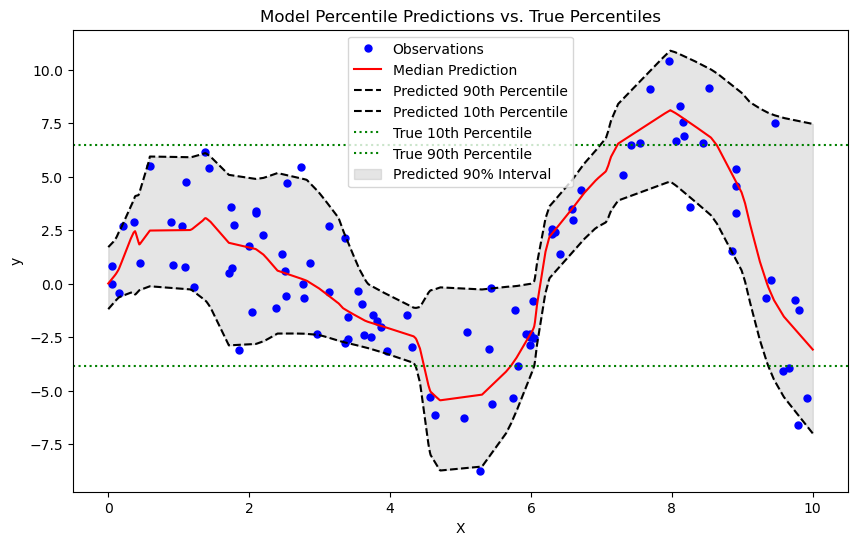

<Figure size 640x480 with 0 Axes>

In [32]:
# Plot the function, the prediction and the 90% confidence interval based on
# the MSE

# True Percentiles
y_lower_true = np.percentile(y, 10)
y_upper_true = np.percentile(y, 90)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(X, y, 'b.', markersize=10, label='Observations')
plt.plot(xx, y_pred, 'r-', label='Median Prediction')
plt.plot(xx, y_upper_pred, 'k--', label='Predicted 90th Percentile')
plt.plot(xx, y_lower_pred, 'k--', label='Predicted 10th Percentile')
plt.axhline(y=y_lower_true, color='g', linestyle=':', label='True 10th Percentile')
plt.axhline(y=y_upper_true, color='g', linestyle=':', label='True 90th Percentile')
plt.fill_between(xx.ravel(), y_lower_pred, y_upper_pred, alpha=0.2, color='gray', label='Predicted 90% Interval')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Model Percentile Predictions vs. True Percentiles')
plt.legend()
plt.show()
plt.savefig('./images/prediction_dummy_data.png')
plt.show()

Percentage in the range (expecting 90%): 92.0
Percentage out of the range (expecting 10%): 8.0


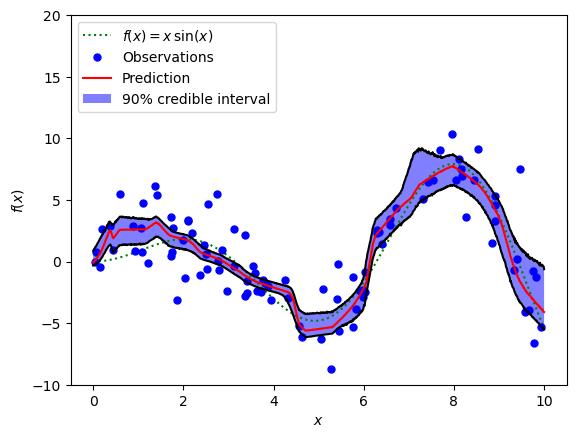

In [33]:
predictions = learner.predict(X)
np.mean(predictions[:, 0]), np.mean(predictions[:, 1]), np.mean(predictions[:, 2])


in_the_range = np.sum((y >= predictions[:, 0]) & (y <= predictions[:, 2]))
print("Percentage in the range (expecting 90%):", in_the_range / len(y) * 100)

out_of_the_range = np.sum((y < predictions[:, 0]) | (y > predictions[:, 2]))
print("Percentage out of the range (expecting 10%):", out_of_the_range / len(y)  * 100)


# ## MC Prediction

K = 5000
tmp = np.zeros((K, xx.shape[0])).astype("float32")
for k in range(K):
    preds = learner.predict(xx, mc=True)
    tmp[k] = preds[:, 1]
y_lower, y_pred, y_upper = np.percentile(tmp, (5, 50, 95), axis=0)    

y_lower[1], y_pred[1], y_upper[1]


# Plot the function, the prediction and the 90% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(xx, f(xx), 'g:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
plt.plot(xx, y_pred, 'r-', label=u'Prediction')
plt.plot(xx, y_upper, 'k-')
plt.plot(xx, y_lower, 'k-')
plt.fill(np.concatenate([xx, xx[::-1]]),
         np.concatenate([y_upper, y_lower[::-1]]),
         alpha=.5, fc='b', ec='None', label='90% credible interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')
plt.show()

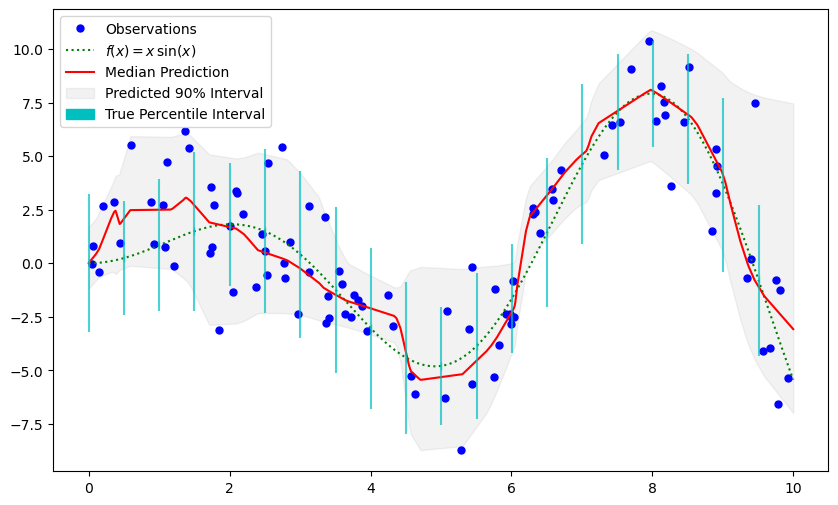

In [36]:
from matplotlib.patches import Patch

np.random.seed(100)

def f(x):
    return x * np.sin(x)

# Generate data
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)
y = f(X).ravel()
dy = 1.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise
y = y.astype(np.float32)

# Predict percentiles using the model
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
xx = xx.astype(np.float32)
predicted_percentiles = learner.predict(xx) # Assuming this gives [lower, median, upper]
y_lower_pred, y_pred, y_upper_pred = predicted_percentiles[:, 0], predicted_percentiles[:, 1], predicted_percentiles[:, 2]

# Calculate dynamic true percentiles for each point in xx
dy_xx = 1.5 + 1.0 * np.random.random(xx.shape[0])  # Ensure dy_xx matches the length of xx
y_lower_true = f(xx).ravel() - 1.645 * dy_xx  # 10th percentile
y_upper_true = f(xx).ravel() + 1.645 * dy_xx  # 90th percentile

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(X, y, 'b.', markersize=10, label='Observations')
plt.plot(xx, f(xx), 'g:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(xx, y_pred, 'r-', label='Median Prediction')
plt.fill_between(xx.ravel(), y_lower_pred, y_upper_pred, alpha=0.1, color='gray', label='Predicted 90% Interval')

# Add vertical bars for true percentiles at regular intervals
interval = 50  # Interval for placing the vertical bars
for i in range(0, len(xx), interval):
    x_val = xx.ravel()[i]
    lower_val = y_lower_true[i]
    upper_val = y_upper_true[i]
    plt.errorbar(x_val, (lower_val + upper_val) / 2, yerr=[[(upper_val - lower_val) / 2]], fmt='c|', alpha=0.7)

# Automatically generate default legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
# Append the custom handler for the vertical bars
handles.append(vertical_bar_proxy)
labels.append('True 90% Interval')
plt.legend(handles=handles, labels=labels, loc="best")

plt.show()

## Extend the model to use two dimensions

In [10]:
## Build the Model

class q_model_2_dimensions(nn.Module):
    def __init__(self, 
                 quantiles, 
                 in_shape=2,  
                 dropout=0.5):     
        super().__init__()
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)
        
        self.in_shape = in_shape
        self.out_shape = len(quantiles)
        self.dropout = dropout
        self.build_model()
        self.init_weights()
        
    def build_model(self): 
        self.base_model = nn.Sequential(
            nn.Linear(self.in_shape, 64),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
            nn.Dropout(self.dropout),
            nn.Linear(64, 64),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
            nn.Dropout(self.dropout),
        )
        final_layers = [
            nn.Linear(64, 1) for _ in range(len(self.quantiles))
        ]
        self.final_layers = nn.ModuleList(final_layers)
        
    def init_weights(self):
        for m in chain(self.base_model, self.final_layers):
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight)
                nn.init.constant_(m.bias, 0)        
        
    def forward(self, x):
        tmp_ = self.base_model(x)
        return torch.cat([layer(tmp_) for layer in self.final_layers], dim=1)


class QuantileLoss_2(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles
        
    def forward(self, preds, target):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        losses = []
        for i, q in enumerate(quantiles):
            errors = target - preds[:, i]
            losses.append(torch.max((q-1) * errors, q * errors).unsqueeze(1))
        loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
        return loss


class Learner_2:
    def __init__(self, model, optimizer_class, loss_func, device='cpu'):
        self.model = model.to(device)
        self.optimizer = optimizer_class(self.model.parameters())
        self.loss_func = loss_func.to(device)
        self.device = device
        self.loss_history = []
        
    def fit(self, x, y, epochs, batch_size):
        self.model.train()
        for e in range(epochs):
            shuffle_idx = np.arange(x.shape[0])
            np.random.shuffle(shuffle_idx)
            x = x[shuffle_idx]
            y = y[shuffle_idx]
            epoch_losses = []
            for idx in range(0, x.shape[0], batch_size):
                self.optimizer.zero_grad()
                batch_x = torch.from_numpy(
                    x[idx : min(idx + batch_size, x.shape[0]),:]
                ).float().to(self.device).requires_grad_(False)
                batch_y = torch.from_numpy(
                    y[idx : min(idx + batch_size, y.shape[0])]
                ).float().to(self.device).requires_grad_(False)
                preds = self.model(batch_x)
                loss = loss_func(preds, batch_y)
                loss.backward()
                self.optimizer.step()
                epoch_losses.append(loss.cpu().detach().numpy())                                
            epoch_loss =  np.mean(epoch_losses)
            self.loss_history.append(epoch_loss)
            if (e+1) % 500 == 0:
                print("Epoch {}: {}".format(e+1, epoch_loss))
                
    def predict(self, x, mc=False):
        if mc:
            self.model.train()
        else:
            self.model.eval()
        return self.model(torch.from_numpy(x).to(self.device).requires_grad_(False)).cpu().detach().numpy()

In [11]:
# Instantiate model for 2D data
quantiles = [.05, .5, .95]
model_2 = q_model_2_dimensions(quantiles, in_shape=2, dropout=0.1)  # in_shape set to 2 for 2D input
loss_func_2 = QuantileLoss_2(quantiles)
learner_2 = Learner_2(model_2, partial(torch.optim.Adam, weight_decay=1e-6), loss_func_2)

# Define X and Y for two-dimensional input
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)
Y = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
Y = Y.astype(np.float32)

# Combine X and Y to create two-dimensional input data
XY = np.concatenate([X, Y], axis=1)

# Define the function for two-dimensional predictions
def g(x, y):
    """The function to predict in 2D."""
    return x * np.sin(x) + y * np.cos(y)

# Update observations for 2D
y_2 = g(XY[:, 0], XY[:, 1]).ravel()
dy = 1.5 + 1.0 * np.random.random(y_2.shape)  # Noise standard deviation
noise = np.random.normal(0, dy)
y_2 += noise
y_2 = y_2.astype(np.float32)

In [12]:
# Run training for 2D model
epochs = 5000
learner_2.fit(XY, y_2, epochs, batch_size=10)

Epoch 500: 2.148761749267578
Epoch 1000: 1.7792625427246094
Epoch 1500: 1.6292937994003296
Epoch 2000: 1.3851492404937744
Epoch 2500: 1.3167914152145386
Epoch 3000: 1.275865077972412
Epoch 3500: 1.351467490196228
Epoch 4000: 1.2077478170394897
Epoch 4500: 1.145952820777893
Epoch 5000: 1.2040449380874634


Assign index to training data to get uncertainty evaluation plot for multi-dimensional data 

In [49]:
# generate some data to test upon
X_test = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X_test = X_test.astype(np.float32)
Y_test = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
Y_test = Y_test.astype(np.float32)

test_data = np.concatenate([X_test, Y_test], axis=1)
print(len(test_data))

100


In [53]:
# Make the prediction on the meshed x-axis
predicted_percentiles = learner_2.predict(test_data)

y_lower_pred, y_pred, y_upper_pred = predicted_percentiles[:, 0], predicted_percentiles[:, 1], predicted_percentiles[:, 2]

100


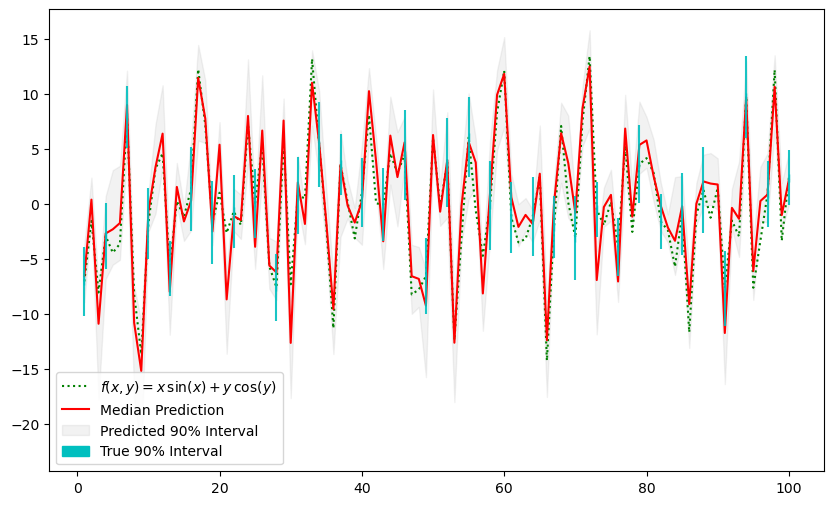

In [70]:
# Calculate dynamic true percentiles for each point in xx
dy_test_data = 1.5 + 1.0 * np.random.random(test_data.shape[0])  # Ensure dy_xx matches the length of xx
y_lower_true = g(X_test, Y_test).ravel() - 1.645 * dy_test_data  # 10th percentile
y_upper_true = g(X_test, Y_test).ravel() + 1.645 * dy_test_data  # 90th percentile

# Plotting
plt.figure(figsize=(10, 6))

test_data_indexed = list(range(1, len(test_data) + 1))

#plt.plot(X_test, y_2, 'b.', markersize=10, label='Observations')
plt.plot(test_data_indexed, g(X_test, Y_test), 'g:', label = r'$f(x, y) = x\,\sin(x) + y \,\cos(y)$')
plt.plot(test_data_indexed, y_pred, 'r-', label='Median Prediction')
plt.fill_between(test_data_indexed, y_lower_pred, y_upper_pred, alpha=0.1, color='gray', label='Predicted 90% Interval')
#range(0, len(test_data), interval)
# Add vertical bars for true percentiles at regular intervals
interval = 3 # Interval for placing the vertical bars
for i in range(0, len(test_data), interval):
    x_val = test_data.ravel()[i]
    lower_val = y_lower_true[i]
    upper_val = y_upper_true[i]
    plt.errorbar(i+1, (lower_val + upper_val) / 2, yerr=[[(upper_val - lower_val) / 2]], fmt='c|', alpha=0.9)

# Automatically generate default legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
# Append the custom handler for the vertical bars
handles.append(vertical_bar_proxy)
labels.append('True 90% Interval')
plt.legend(handles=handles, labels=labels, loc="best")

plt.show()

In [ ]:
# TODO: in the above graph add the y-values so they can be seen?

## Review model results 

In [16]:
def calculate_picp(actual_values, lower_bounds, upper_bounds):
    """
    Calculate the Prediction Interval Coverage Probability (PICP).

    Parameters:
    actual_values (array-like): The actual observed values.
    lower_bounds (array-like): The lower bounds of the prediction intervals.
    upper_bounds (array-like): The upper bounds of the prediction intervals.

    Returns:
    float: The PICP value.
    """
    coverage = np.sum((actual_values >= lower_bounds) & (actual_values <= upper_bounds))
    picp = coverage / len(actual_values)
    return picp

def calculate_pinaw(actual_values, lower_bounds, upper_bounds):
    """
    Calculate the Prediction Interval Normalized Average Width (PINAW).

    Parameters:
    actual_values (array-like): The actual observed values.
    lower_bounds (array-like): The lower bounds of the prediction intervals.
    upper_bounds (array-like): The upper bounds of the prediction intervals.

    Returns:
    float: The PINAW value.
    """
    interval_widths = upper_bounds - lower_bounds
    data_range = np.max(actual_values) - np.min(actual_values)
    normalized_widths = interval_widths / data_range
    pinaw = np.mean(normalized_widths)
    return pinaw

def calculate_cwc(actual_values, lower_bounds, upper_bounds, picp_threshold=0.9):
    """
    Calculate the Coverage Width-based Criterion (CWC).

    Parameters:
    actual_values (array-like): The actual observed values.
    lower_bounds (array-like): The lower bounds of the prediction intervals.
    upper_bounds (array-like): The upper bounds of the prediction intervals.
    picp_threshold (float): The desired threshold for PICP.

    Returns:
    float: The CWC value.
    """
    picp = calculate_picp(actual_values, lower_bounds, upper_bounds)
    pinaw = calculate_pinaw(actual_values, lower_bounds, upper_bounds)
    
    # CWC formula can vary. Here's one common approach:
    if picp < picp_threshold:
        cwc = pinaw * (1 + np.exp(-10 * (picp - picp_threshold)))
    else:
        cwc = pinaw

    return cwc

## Real data for the model

To continue modeling with more realistic data I chose house prices for advanced regression dataset from Kaggle: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

In [17]:
train_df = pd.read_csv("data/train.csv")
train_df = train_df.drop('Id', axis=1)

In [18]:
train_df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [19]:
def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(train_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

1160 examples in training, 300 examples in testing.


In [20]:
X = train_df["MSSubClass"].values.reshape(-1, 1)
y = train_df["SalePrice"].values
display(X.shape)
display(y.shape)
# ((100, 1), (100,), (1000, 1))

(1460, 1)

(1460,)

In [21]:
# Instantiate model
quantiles = [.05, .5, .95]
model = q_model(quantiles, dropout=0.1)
loss_func = QuantileLoss(quantiles)
learner = Learner(model, partial(torch.optim.Adam, weight_decay=1e-6), loss_func)


# ## Train the Model

# Run training
epochs = 1000 # TODO: change if actual run
learner.fit(X, y, epochs, batch_size=10)

Epoch 500: 45118.91015625
Epoch 1000: 44440.47265625


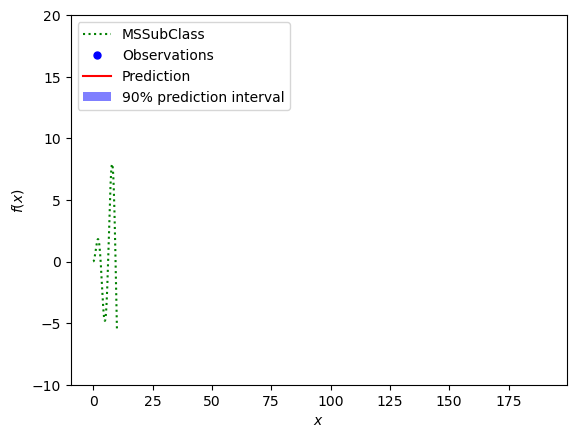

In [22]:
# TODO: FIX THIS
# Make the prediction on the meshed x-axis
tmp = learner.predict(xx)
y_lower, y_pred, y_upper = tmp[:, 0], tmp[:, 1], tmp[:, 2]

# Plot the function, the prediction and the 90% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(xx, f(xx), 'g:', label='MSSubClass')
plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
plt.plot(xx, y_pred, 'r-', label=u'Prediction')
plt.plot(xx, y_upper, 'k-')
plt.plot(xx, y_lower, 'k-')
plt.fill(np.concatenate([xx, xx[::-1]]),
         np.concatenate([y_upper, y_lower[::-1]]),
         alpha=.5, fc='b', ec='None', label='90% prediction interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')
plt.show()

In [23]:
values_to_predict = np.unique(X).reshape(15, 1).astype(np.float32)
values_to_predict.shape
tmp = learner.predict(values_to_predict)
#tmp

In [24]:
tmp

array([[ 86385.3  , 156762.72 , 339856.03 ],
       [ 87965.28 , 160686.8  , 342647.94 ],
       [ 89545.27 , 164610.84 , 345439.88 ],
       [ 90335.26 , 166572.88 , 346835.8  ],
       [ 91125.266, 168534.94 , 348231.8  ],
       [ 92705.24 , 172458.98 , 351023.75 ],
       [ 93124.69 , 173378.69 , 347691.38 ],
       [ 92553.41 , 171816.06 , 341904.44 ],
       [ 91982.12 , 170253.42 , 336117.5  ],
       [ 91410.836, 168690.78 , 330330.56 ],
       [ 90839.56 , 167128.14 , 324543.62 ],
       [ 87411.875, 157752.31 , 289822.   ],
       [ 82841.63 , 145251.23 , 243526.5  ],
       [ 80556.51 , 139000.67 , 220378.73 ],
       [ 79875.69 , 136781.55 , 210892.8  ]], dtype=float32)

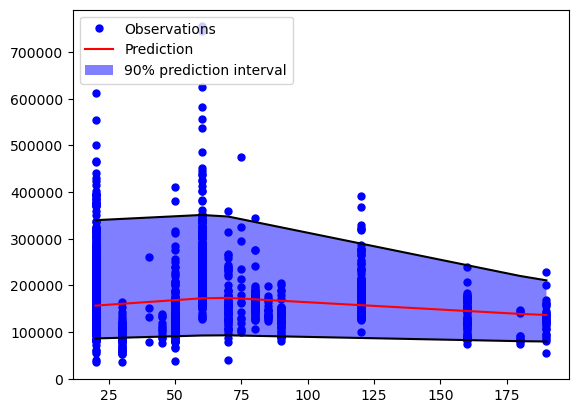

In [25]:
y_lower, y_pred, y_upper = tmp[:, 0], tmp[:, 1], tmp[:, 2]

# Plot the function, the prediction and the 90% confidence interval based on
# the MSE
fig = plt.figure()
#plt.plot(xx, f(xx), 'g:', label='MSSubClass')
plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
plt.plot(values_to_predict, y_pred, 'r-', label=u'Prediction')
plt.plot(values_to_predict, y_upper, 'k-')
plt.plot(values_to_predict, y_lower, 'k-')
plt.fill(np.concatenate([values_to_predict, values_to_predict[::-1]]),
         np.concatenate([y_upper, y_lower[::-1]]),
         alpha=.5, fc='b', ec='None', label='90% prediction interval')
#plt.xlabel('$x$')
#plt.ylabel('$f(x)$')
#plt.ylim(-10, 20)
plt.legend(loc='upper left')
plt.show()

Extend the new data to new dimension